# pycsp3-scheduling: API Reference & Interactive Tutorials

This notebook provides comprehensive documentation and interactive examples for the pycsp3-scheduling library.

**pycsp3-scheduling** extends [pycsp3](https://pycsp.org) with scheduling support including:
- Interval variables for tasks/activities
- Sequence variables for machine scheduling
- Precedence and grouping constraints
- Cumulative functions for resource modeling
- State functions for discrete resource states
- Visualization for Gantt charts and resource profiles

## Table of Contents

1. [Import and Setup](#1-import-and-setup)
2. [IntervalVar API Reference](#2-intervalvar-api-reference)
3. [SequenceVar API Reference](#3-sequencevar-api-reference)
4. [Precedence Constraints API](#4-precedence-constraints-api)
5. [Grouping Constraints API](#5-grouping-constraints-api)
6. [Cumulative Functions API](#6-cumulative-functions-api)
7. [State Functions API](#7-state-functions-api)
8. [Visualization API](#8-visualization-api)
9. [Tutorial: Basic Job Shop Modeling](#9-tutorial-basic-job-shop-modeling)
10. [Tutorial: Flexible Job Shop](#10-tutorial-flexible-job-shop)
11. [Tutorial: RCPSP](#11-tutorial-rcpsp)
12. [Tutorial: Sequences and NoOverlap](#12-tutorial-sequences-and-nooverlap)
13. [Tutorial: Cumulative Resources](#13-tutorial-cumulative-resources)
14. [Tutorial: State Functions](#14-tutorial-state-functions)

## 1. Import and Setup

Import the core modules from pycsp3-scheduling and pycsp3:

In [28]:
# Core pycsp3 imports
from pycsp3 import satisfy, minimize, solve, SAT, OPTIMUM, Maximum, Sum, Var

# pycsp3-scheduling: Variables
from pycsp3_scheduling import (
    IntervalVar, IntervalVarArray, IntervalVarDict,
    SequenceVar, SequenceVarArray,
    INTERVAL_MIN, INTERVAL_MAX,
)

# pycsp3-scheduling: Expressions
from pycsp3_scheduling import (
    start_of, end_of, size_of, length_of, presence_of,
    overlap_length, expr_min, expr_max,
)

# pycsp3-scheduling: Interop (for pycsp3 integration)
from pycsp3_scheduling import start_time, end_time, presence_time, interval_value

# pycsp3-scheduling: Constraints
from pycsp3_scheduling import (
    # Precedence
    end_before_start, start_before_start, end_before_end, start_before_end,
    start_at_start, start_at_end, end_at_start, end_at_end,
    # Grouping
    span, alternative, synchronize,
    # Sequence
    SeqNoOverlap, first, last, before, previous,
    same_sequence, same_common_subsequence,
)

# pycsp3-scheduling: Cumulative Functions
from pycsp3_scheduling import (
    CumulFunction, pulse, step_at, step_at_start, step_at_end,
    cumul_range, always_in, height_at_start, height_at_end,
)

# pycsp3-scheduling: State Functions
from pycsp3_scheduling import (
    StateFunction, TransitionMatrix,
    always_equal, always_constant, always_no_state,
)

print("✓ All imports successful!")
print(f"pycsp3-scheduling loaded")

✓ All imports successful!
pycsp3-scheduling loaded


## 2. IntervalVar API Reference

### Creating Interval Variables

An `IntervalVar` represents a task or activity with:
- **start**: Start time bounds `(min, max)` or fixed `int`
- **end**: End time bounds `(min, max)` or fixed `int`
- **size**: Duration bounds `(min, max)` or fixed `int`
- **length**: Length bounds (can differ from size with intensity functions)
- **optional**: If `True`, the interval may be absent
- **name**: Unique identifier

In [29]:
# Reset registry for clean examples
from pycsp3_scheduling.variables.interval import clear_interval_registry
clear_interval_registry()

# Fixed duration task
task1 = IntervalVar(size=10, name="task1")
print(f"task1: size=[{task1.size_min}, {task1.size_max}], is_fixed_size={task1.is_fixed_size}")

# Variable duration task
task2 = IntervalVar(size=(5, 20), name="task2")
print(f"task2: size=[{task2.size_min}, {task2.size_max}], is_fixed_size={task2.is_fixed_size}")

# Task with bounded start and end
task3 = IntervalVar(start=(0, 100), end=(10, 200), size=10, name="task3")
print(f"task3: start=[{task3.start_min}, {task3.start_max}], end=[{task3.end_min}, {task3.end_max}]")

# Optional task (can be absent from solution)
task4 = IntervalVar(size=15, optional=True, name="optional_task")
print(f"task4: optional={task4.is_optional}, is_present={task4.is_present}")

task1: size=[10, 10], is_fixed_size=True
task2: size=[5, 20], is_fixed_size=False
task3: start=[0, 100], end=[10, 200]
task4: optional=True, is_present=False


### IntervalVarArray and IntervalVarDict

Factory functions for creating collections of interval variables:

In [30]:
# Create 1D array of intervals
tasks = IntervalVarArray(5, size_range=10, name="task")
print(f"Created {len(tasks)} tasks: {[t.name for t in tasks]}")

# Create 2D array (jobs × operations)
ops = IntervalVarArray((3, 4), size_range=(5, 15), optional=True, name="op")
print(f"2D array shape: {len(ops)} x {len(ops[0])}")
print(f"ops[1][2].name = {ops[1][2].name}")

# Create dictionary of intervals
stages = IntervalVarDict(
    keys=["assembly", "testing", "packaging"],
    size_range=20,
    name="stage"
)
print(f"Stage keys: {list(stages.keys())}")
print(f"stages['testing'].size_min = {stages['testing'].size_min}")

Created 5 tasks: ['task[0]', 'task[1]', 'task[2]', 'task[3]', 'task[4]']
2D array shape: 3 x 4
ops[1][2].name = op[1][2]
Stage keys: ['assembly', 'testing', 'packaging']
stages['testing'].size_min = 20


## 3. SequenceVar API Reference

A `SequenceVar` represents an ordered sequence of intervals on a disjunctive resource (e.g., a machine):

In [31]:
clear_interval_registry()

# Create tasks for a machine
machine_tasks = [IntervalVar(size=10, name=f"m_task{i}") for i in range(4)]

# Simple sequence (no types)
machine = SequenceVar(intervals=machine_tasks, name="machine1")
print(f"Sequence '{machine.name}' has {len(machine)} intervals")
print(f"has_types: {machine.has_types}")

# Sequence with types (for transition matrices)
job_types = [0, 1, 0, 1]  # Type per task
typed_machine = SequenceVar(
    intervals=machine_tasks,
    types=job_types,
    name="machine_with_types"
)
print(f"\nTyped sequence: has_types={typed_machine.has_types}")
print(f"Task 2 type: {typed_machine.get_type(2)}")
print(f"Tasks of type 0: {[t.name for t in typed_machine.get_intervals_by_type(0)]}")

Sequence 'machine1' has 4 intervals
has_types: False

Typed sequence: has_types=True
Task 2 type: 0
Tasks of type 0: ['m_task0', 'm_task2']


## 4. Precedence Constraints API

Precedence constraints define temporal relationships between intervals.

### Before Constraints (Inequalities)

| Constraint | Semantics |
|------------|-----------|
| `end_before_start(a, b, delay=0)` | `start(b) >= end(a) + delay` |
| `start_before_start(a, b, delay=0)` | `start(b) >= start(a) + delay` |
| `end_before_end(a, b, delay=0)` | `end(b) >= end(a) + delay` |
| `start_before_end(a, b, delay=0)` | `end(b) >= start(a) + delay` |

### At Constraints (Equalities)

| Constraint | Semantics |
|------------|-----------|
| `start_at_start(a, b, delay=0)` | `start(b) == start(a) + delay` |
| `start_at_end(a, b, delay=0)` | `start(b) == end(a) + delay` |
| `end_at_start(a, b, delay=0)` | `end(a) == start(b) + delay` |
| `end_at_end(a, b, delay=0)` | `end(b) == end(a) + delay` |

In [32]:
clear_interval_registry()

# Create example tasks
task_a = IntervalVar(size=10, name="A")
task_b = IntervalVar(size=15, name="B")

# Basic precedence: A must finish before B starts
constraint1 = end_before_start(task_a, task_b)
print(f"end_before_start(A, B): {constraint1}")

# With delay: A must finish at least 5 units before B starts
constraint2 = end_before_start(task_a, task_b, delay=5)
print(f"end_before_start(A, B, delay=5): {constraint2}")

# Synchronization: A and B start together
constraint3 = start_at_start(task_a, task_b)
print(f"start_at_start(A, B): {constraint3}")

# Chain: A ends exactly when B starts (no gap)
constraint4 = start_at_end(task_a, task_b)
print(f"start_at_end(A, B): B starts when A ends")

end_before_start(A, B): le(add(iv_s_0,10),iv_s_1)
end_before_start(A, B, delay=5): le(add(iv_s_0,15),iv_s_1)
start_at_start(A, B): eq(iv_s_1,iv_s_0)
start_at_end(A, B): B starts when A ends


## 5. Grouping Constraints API

### span(main, subtasks)
Main interval spans all present subtasks (starts at earliest, ends at latest).

### alternative(main, alternatives, cardinality=1)
Select exactly `cardinality` alternatives that match the main interval.

### synchronize(main, intervals)
All present intervals synchronize with main interval (same start/end).

In [33]:
clear_interval_registry()

# Example: span constraint
# Main task spans all its subtasks
main_task = IntervalVar(name="project")
phase1 = IntervalVar(size=10, name="phase1")
phase2 = IntervalVar(size=15, name="phase2")
phase3 = IntervalVar(size=8, name="phase3")

span_constraint = span(main_task, [phase1, phase2, phase3])
print(f"span(main, [phase1, phase2, phase3]):")
print(f"  -> {span_constraint}")

# Example: alternative constraint
# Select exactly 1 machine to process the task
task = IntervalVar(size=10, name="task")
on_machine1 = IntervalVar(size=10, optional=True, name="on_m1")
on_machine2 = IntervalVar(size=12, optional=True, name="on_m2")
on_machine3 = IntervalVar(size=8, optional=True, name="on_m3")

alt_constraint = alternative(task, [on_machine1, on_machine2, on_machine3])
print(f"\nalternative(task, [on_m1, on_m2, on_m3]):")
print(f"  -> {alt_constraint}")

# Example: synchronize constraint
# All subtasks must match the main interval timing
meeting = IntervalVar(size=60, name="meeting")
attendee1 = IntervalVar(optional=True, name="attendee1")
attendee2 = IntervalVar(optional=True, name="attendee2")

sync_constraint = synchronize(meeting, [attendee1, attendee2])
print(f"\nsynchronize(meeting, [attendee1, attendee2]):")
print(f"  -> {sync_constraint}")

span(main, [phase1, phase2, phase3]):
  -> [eq(iv_s_0,min(iv_s_1,iv_s_2,iv_s_3)), eq(add(iv_s_0,iv_l_0),max(add(iv_s_1,10),add(iv_s_2,15),add(iv_s_3,8)))]

alternative(task, [on_m1, on_m2, on_m3]):
  -> [eq(add(iv_p_5,iv_p_6,iv_p_7),1), or(eq(iv_p_5,0),eq(iv_s_5,iv_s_4)), or(eq(iv_p_5,0),eq(add(iv_s_5,10),add(iv_s_4,10))), or(eq(iv_p_6,0),eq(iv_s_6,iv_s_4)), or(eq(iv_p_6,0),eq(add(iv_s_6,12),add(iv_s_4,10))), or(eq(iv_p_7,0),eq(iv_s_7,iv_s_4)), or(eq(iv_p_7,0),eq(add(iv_s_7,8),add(iv_s_4,10)))]

synchronize(meeting, [attendee1, attendee2]):
  -> [or(eq(iv_p_9,0),eq(iv_s_9,iv_s_8)), or(eq(iv_p_9,0),eq(add(iv_s_9,iv_l_9),add(iv_s_8,60))), or(eq(iv_p_10,0),eq(iv_s_10,iv_s_8)), or(eq(iv_p_10,0),eq(add(iv_s_10,iv_l_10),add(iv_s_8,60)))]


## 6. Cumulative Functions API

Cumulative functions model resource usage over time.

| Function | Description |
|----------|-------------|
| `pulse(interval, height)` | Resource used during interval execution |
| `step_at_start(interval, height)` | Step increase at interval start |
| `step_at_end(interval, height)` | Step increase at interval end |
| `step(time, height)` | Step increase at fixed time point |
| `cumul_range(func, min, max)` | Constrain cumulative function range |

In [34]:
clear_interval_registry()

# Example: Cumulative resource with capacity constraint
task1 = IntervalVar(size=10, name="task1")
task2 = IntervalVar(size=15, name="task2")
task3 = IntervalVar(size=8, name="task3")

# Each task uses some capacity during execution
p1 = pulse(task1, 3)  # Uses 3 units
p2 = pulse(task2, 2)  # Uses 2 units
p3 = pulse(task3, 4)  # Uses 4 units

print(f"pulse(task1, 3) -> {p1}")
print(f"pulse(task2, 2) -> {p2}")
print(f"pulse(task3, 4) -> {p3}")

# Combine into cumulative function and constrain
cumul = p1 + p2 + p3
capacity_constraint = cumul_range(cumul, 0, 5)  # Max capacity of 5
print(f"\ncumul_range(p1 + p2 + p3, 0, 5) -> {capacity_constraint}")

# Example: Step functions for inventory/state changes
incoming = IntervalVar(size=5, name="delivery")
outgoing = IntervalVar(size=3, name="shipment")

# Inventory increases at delivery end, decreases at shipment start
inv_up = step_at_end(incoming, 10)   # +10 units delivered
inv_down = step_at_start(outgoing, -5)  # -5 units shipped

print(f"\nstep_at_end(delivery, 10) -> {inv_up}")
print(f"step_at_start(shipment, -5) -> {inv_down}")

pulse(task1, 3) -> pulse(task1, 3)
pulse(task2, 2) -> pulse(task2, 2)
pulse(task3, 4) -> pulse(task3, 4)

cumul_range(p1 + p2 + p3, 0, 5) -> 0 <= CumulFunction(pulse(task1, 3) + pulse(task2, 2) + pulse(task3, 4)) <= 5

step_at_end(delivery, 10) -> step_at_end(delivery, 10)
step_at_start(shipment, -5) -> step_at_start(shipment, -5)


## 7. State Functions API

State functions model resource states that change over time (e.g., machine configurations).

| Function | Description |
|----------|-------------|
| `StateFunction(name)` | Create a state function |
| `TransitionMatrix(matrix)` | Create transition matrix from 2D list |
| `always_equal(func, interval, state)` | State equals value during interval |
| `always_constant(func, interval)` | State constant during interval |

In [35]:
clear_interval_registry()

# Example: Machine with different configurations (states)
# States: 0=idle, 1=setup_A, 2=setup_B, 3=processing

# Create state function for machine configuration
machine_state = StateFunction("machine")
print(f"StateFunction: {machine_state}")

# Transition matrix: time to change between states
# transitions[from_state][to_state] = time required
# Create 4x4 matrix for 4 states
transitions = TransitionMatrix([
    [0, 5, 5, 0],   # From idle: to setup_A=5, to setup_B=5
    [0, 0, 10, 0],  # From setup_A: to setup_B=10
    [0, 10, 0, 0],  # From setup_B: to setup_A=10
    [0, 0, 0, 0],   # From processing
])
print(f"\nTransitionMatrix:\n{transitions}")
print(f"Time from setup_A to setup_B: {transitions[1, 2]}")

# Tasks require specific machine states
task_a1 = IntervalVar(size=20, name="task_A1")
task_a2 = IntervalVar(size=15, name="task_A2")
task_b1 = IntervalVar(size=25, name="task_B1")

# Task A1 and A2 require setup_A (state 1)
state_a1 = always_equal(machine_state, task_a1, 1)
state_a2 = always_equal(machine_state, task_a2, 1)

# Task B1 requires setup_B (state 2)
state_b1 = always_equal(machine_state, task_b1, 2)

print(f"\nalways_equal(machine, task_A1, 1) -> {state_a1}")
print(f"always_equal(machine, task_B1, 2) -> {state_b1}")

StateFunction: StateFunction('machine')

TransitionMatrix:
TransitionMatrix(4x4)
Time from setup_A to setup_B: 10

always_equal(machine, task_A1, 1) -> always_equal(machine, task_A1, 1)
always_equal(machine, task_B1, 2) -> always_equal(machine, task_B1, 2)


## 8. Visualization API

The `visu` module provides Gantt chart visualization for scheduling solutions.

| Function | Description |
|----------|-------------|
| `visu.timeline(title, origin, horizon)` | Create a new timeline |
| `visu.panel(name)` | Add a panel (machine/resource row) |
| `visu.interval(start, end, name, color)` | Draw an interval bar |
| `visu.segment(start, end, value)` | Draw a function segment |
| `visu.pause(start, end, name)` | Draw a pause/maintenance period |
| `visu.show()` | Display the visualization |

Visualization enabled: True
Timeline created with 2 machine panels and 1 resource panel
Call visu.show() to display (requires matplotlib)


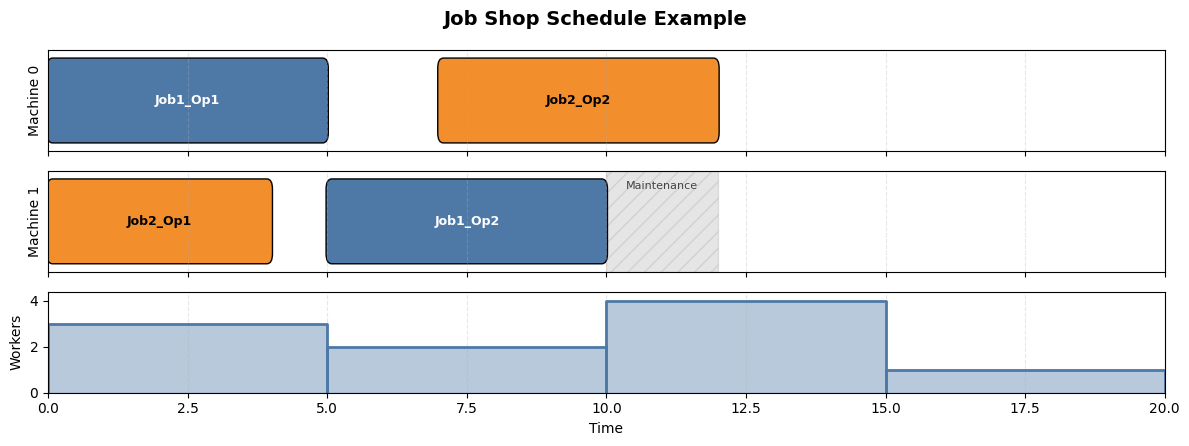

In [36]:
# Import visualization module
from pycsp3_scheduling import visu

# Check if visualization is enabled (matplotlib available)
print(f"Visualization enabled: {visu.is_visu_enabled()}")

# Reset any previous visualization state
visu.reset()

# Example: Create a Gantt chart for a job shop schedule
visu.timeline("Job Shop Schedule Example", origin=0, horizon=20)

# Machine 0 panel
visu.panel("Machine 0")
visu.interval(0, 5, "Job1_Op1", color=0)
visu.interval(7, 12, "Job2_Op2", color=1)

# Machine 1 panel  
visu.panel("Machine 1")
visu.interval(0, 4, "Job2_Op1", color=1)
visu.interval(5, 10, "Job1_Op2", color=0)
visu.pause(10, 12, "Maintenance")  # Show a maintenance break

# Resource panel with cumulative usage
visu.panel("Workers")
visu.segment(0, 5, 3)   # 3 workers from 0-5
visu.segment(5, 10, 2)  # 2 workers from 5-10
visu.segment(10, 15, 4) # 4 workers from 10-15
visu.segment(15, 20, 1) # 1 worker from 15-20

print("Timeline created with 2 machine panels and 1 resource panel")
print("Call visu.show() to display (requires matplotlib)")

visu.show()

### Visualizing Solved Intervals

After solving, use `interval_value()` to get the solution values and display them:

Visualization created from solution values
Each job has a distinct color


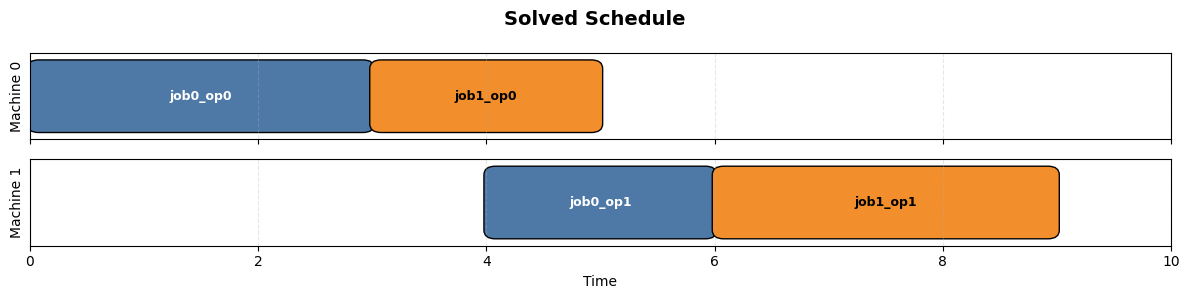

In [37]:
# Example: Displaying solved interval values
# After solving with solve(), use interval_value() to get results

# Simulated solution values (as if solve() returned SAT/OPTIMUM)
# In practice you would use: result = interval_value(task)
solution = {
    "job0": [{"start": 0, "end": 3}, {"start": 4, "end": 6}],  # Job 0 ops
    "job1": [{"start": 3, "end": 5}, {"start": 6, "end": 9}],  # Job 1 ops
}

machines = {
    "job0": [0, 1],  # Job 0: machine for each op
    "job1": [0, 1],  # Job 1: machine for each op
}

# Create visualization from solution
visu.reset()
visu.timeline("Solved Schedule", origin=0, horizon=10)

# Group operations by machine and display
for m in range(2):
    visu.panel(f"Machine {m}")
    for job_id, ops in solution.items():
        job_num = int(job_id[-1])
        for op_idx, op_val in enumerate(ops):
            if machines[job_id][op_idx] == m:
                visu.interval(
                    op_val["start"], 
                    op_val["end"], 
                    f"{job_id}_op{op_idx}",
                    color=job_num  # Color by job
                )

print("Visualization created from solution values")
print("Each job has a distinct color")
visu.show()

---

# Part 2: Interactive Tutorials

Now let's apply these concepts to solve real scheduling problems!

## Tutorial 1: Simple Job Shop Scheduling

**Problem**: Schedule 2 jobs on 2 machines. Each job has 2 operations that must run in order. Each machine can process one operation at a time.

```
Job 1: Machine1(3) → Machine2(2)
Job 2: Machine2(4) → Machine1(2)
```

**Goal**: Minimize makespan (total completion time).

In [11]:
clear_interval_registry()

# Problem data
# jobs[job_id] = [(machine_id, processing_time), ...]
jobs = {
    0: [(0, 3), (1, 2)],  # Job 0: Machine0 for 3, then Machine1 for 2
    1: [(1, 4), (0, 2)],  # Job 1: Machine1 for 4, then Machine0 for 2
}

n_jobs = len(jobs)
n_machines = 2

# Create interval variables for each operation
# operations[job][op_index] = IntervalVar
operations = {}
for job, ops in jobs.items():
    operations[job] = []
    for op_idx, (machine, duration) in enumerate(ops):
        iv = IntervalVar(
            size=duration,
            name=f"job{job}_op{op_idx}_m{machine}"
        )
        operations[job].append((iv, machine))
        
print("Created interval variables:")
for job, ops in operations.items():
    for iv, machine in ops:
        print(f"  {iv.name}: size={iv.size_min} on machine {machine}")

Created interval variables:
  job0_op0_m0: size=3 on machine 0
  job0_op1_m1: size=2 on machine 1
  job1_op0_m1: size=4 on machine 1
  job1_op1_m0: size=2 on machine 0


In [12]:
# Add precedence constraints: operations within a job must run in order
precedence_constraints = []

for job, ops in operations.items():
    for i in range(len(ops) - 1):
        iv_before, _ = ops[i]
        iv_after, _ = ops[i + 1]
        constraint = end_before_start(iv_before, iv_after)
        precedence_constraints.append(constraint)
        print(f"Precedence: {iv_before.name} -> {iv_after.name}")

print(f"\nTotal precedence constraints: {len(precedence_constraints)}")

Precedence: job0_op0_m0 -> job0_op1_m1
Precedence: job1_op0_m1 -> job1_op1_m0

Total precedence constraints: 2


In [13]:
# Add machine constraints: no two operations on same machine can overlap
# Group operations by machine
machine_ops = {m: [] for m in range(n_machines)}
for job, ops in operations.items():
    for iv, machine in ops:
        machine_ops[machine].append(iv)

# Create sequence variables for each machine
sequences = {}
for machine, ops in machine_ops.items():
    seq = SequenceVar(intervals=ops, name=f"machine{machine}")
    sequences[machine] = seq
    print(f"Machine {machine} sequence: {[iv.name for iv in ops]}")

# No overlap constraint on each machine
no_overlap_constraints = []
for machine, seq in sequences.items():
    constraint = SeqNoOverlap(seq)
    no_overlap_constraints.append(constraint)
    print(f"NoOverlap on machine {machine}: {constraint}")

print(f"\nTotal machine constraints: {len(no_overlap_constraints)}")

Machine 0 sequence: ['job0_op0_m0', 'job1_op1_m0']
Machine 1 sequence: ['job0_op1_m1', 'job1_op0_m1']
NoOverlap on machine 0: <pycsp3.classes.entities.ECtr object at 0x111a6e840>
NoOverlap on machine 1: <pycsp3.classes.entities.ECtr object at 0x111a6e8a0>

Total machine constraints: 2


In [14]:
# Summary of the Job Shop model
print("=" * 50)
print("Job Shop Scheduling Model Summary")
print("=" * 50)
print(f"\nVariables:")
print(f"  - {sum(len(ops) for ops in operations.values())} interval variables (operations)")
print(f"  - {len(sequences)} sequence variables (machines)")
print(f"\nConstraints:")
print(f"  - {len(precedence_constraints)} precedence constraints")
print(f"  - {len(no_overlap_constraints)} no-overlap constraints")
print(f"\nObjective: Minimize makespan (max end time of all operations)")

# To solve this, you would:
# 1. Post all constraints to pycsp3
# 2. Add makespan variable and minimize it
# 3. Call a constraint solver

Job Shop Scheduling Model Summary

Variables:
  - 4 interval variables (operations)
  - 2 sequence variables (machines)

Constraints:
  - 2 precedence constraints
  - 2 no-overlap constraints

Objective: Minimize makespan (max end time of all operations)


## Tutorial 2: Resource-Constrained Project Scheduling (RCPSP)

**Problem**: Schedule project activities with:
- Precedence relations between activities
- Limited renewable resource capacity

```
Activities: A(5), B(3), C(4), D(6)
Precedence: A → B, A → C, B → D, C → D
Resource capacity: 3 units
Resource usage: A=2, B=1, C=2, D=1
```

In [15]:
clear_interval_registry()

# Activity data: (duration, resource_usage)
activities = {
    'A': (5, 2),
    'B': (3, 1),
    'C': (4, 2),
    'D': (6, 1),
}

# Precedence relations
precedences = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'D'),
    ('C', 'D'),
]

# Resource capacity
resource_capacity = 3

# Create interval variables
tasks = {}
for name, (duration, _) in activities.items():
    tasks[name] = IntervalVar(size=duration, name=name)
    print(f"Activity {name}: duration={duration}")

print(f"\nCreated {len(tasks)} activity intervals")

Activity A: duration=5
Activity B: duration=3
Activity C: duration=4
Activity D: duration=6

Created 4 activity intervals


In [16]:
# Add precedence constraints
prec_constraints = []
for before, after in precedences:
    constraint = end_before_start(tasks[before], tasks[after])
    prec_constraints.append(constraint)
    print(f"Precedence: {before} → {after}")

# Add resource constraint using cumulative function
resource_usage = None
for name, (_, usage) in activities.items():
    p = pulse(tasks[name], usage)
    if resource_usage is None:
        resource_usage = p
    else:
        resource_usage = resource_usage + p
    print(f"Activity {name} uses {usage} units")

# Constrain cumulative resource usage
resource_constraint = cumul_range(resource_usage, 0, resource_capacity)
print(f"\nResource capacity constraint: 0 <= usage <= {resource_capacity}")
print(f"Constraint: {resource_constraint}")

Precedence: A → B
Precedence: A → C
Precedence: B → D
Precedence: C → D
Activity A uses 2 units
Activity B uses 1 units
Activity C uses 2 units
Activity D uses 1 units

Resource capacity constraint: 0 <= usage <= 3
Constraint: 0 <= CumulFunction(pulse(A, 2) + pulse(B, 1) + pulse(C, 2) + pulse(D, 1)) <= 3


## Tutorial 3: Flexible Job Shop with Alternative Machines

**Problem**: Jobs can be processed on alternative machines with different processing times.

```
Job 1, Op 1: Machine1(5) OR Machine2(4)
Job 1, Op 2: Machine2(3) OR Machine3(2)
```

**Key concept**: Use `alternative()` to model machine choice.

In [17]:
clear_interval_registry()

# Flexible operation data
# operation = [(machine_id, duration), ...]
flexible_ops = {
    ('job1', 0): [(0, 5), (1, 4)],           # Op1: M1(5) or M2(4)
    ('job1', 1): [(1, 3), (2, 2)],           # Op2: M2(3) or M3(2)
    ('job2', 0): [(0, 3), (2, 4)],           # Op1: M1(3) or M3(4)
    ('job2', 1): [(0, 2), (1, 3), (2, 2)],   # Op2: any machine
}

n_machines = 3

# Create main operation intervals (abstract timing)
main_ops = {}
for (job, op_idx), alternatives in flexible_ops.items():
    # Main interval: variable size based on machine choice
    min_dur = min(dur for _, dur in alternatives)
    max_dur = max(dur for _, dur in alternatives)
    main_ops[(job, op_idx)] = IntervalVar(
        size=(min_dur, max_dur),
        name=f"{job}_op{op_idx}"
    )
    print(f"{job}_op{op_idx}: size in [{min_dur}, {max_dur}]")

print(f"\nCreated {len(main_ops)} main operation intervals")

job1_op0: size in [4, 5]
job1_op1: size in [2, 3]
job2_op0: size in [3, 4]
job2_op1: size in [2, 3]

Created 4 main operation intervals


In [18]:
# Create alternative intervals for each machine choice
machine_intervals = {m: [] for m in range(n_machines)}
alternative_constraints = []

for (job, op_idx), alternatives in flexible_ops.items():
    main = main_ops[(job, op_idx)]
    alt_intervals = []
    
    for machine, duration in alternatives:
        alt_iv = IntervalVar(
            size=duration,
            optional=True,  # May or may not be selected
            name=f"{job}_op{op_idx}_m{machine}"
        )
        alt_intervals.append(alt_iv)
        machine_intervals[machine].append(alt_iv)
    
    # Exactly one alternative must be selected
    alt_constraint = alternative(main, alt_intervals)
    alternative_constraints.append(alt_constraint)
    
    print(f"{main.name}: alternatives = {[iv.name for iv in alt_intervals]}")

print(f"\nCreated {len(alternative_constraints)} alternative constraints")

job1_op0: alternatives = ['job1_op0_m0', 'job1_op0_m1']
job1_op1: alternatives = ['job1_op1_m1', 'job1_op1_m2']
job2_op0: alternatives = ['job2_op0_m0', 'job2_op0_m2']
job2_op1: alternatives = ['job2_op1_m0', 'job2_op1_m1', 'job2_op1_m2']

Created 4 alternative constraints


In [19]:
# No overlap on each machine (among selected alternatives)
machine_sequences = {}
for machine, intervals in machine_intervals.items():
    if intervals:
        seq = SequenceVar(intervals=intervals, name=f"machine{machine}")
        machine_sequences[machine] = seq
        no_overlap = SeqNoOverlap(seq)
        print(f"Machine {machine}: {len(intervals)} optional operations")

# Job precedence: operations within each job must be ordered
for job in ['job1', 'job2']:
    ops_in_job = sorted([k for k in main_ops.keys() if k[0] == job])
    for i in range(len(ops_in_job) - 1):
        before = main_ops[ops_in_job[i]]
        after = main_ops[ops_in_job[i + 1]]
        prec = end_before_start(before, after)
        print(f"Precedence: {before.name} → {after.name}")

Machine 0: 3 optional operations
Machine 1: 3 optional operations
Machine 2: 3 optional operations
Precedence: job1_op0 → job1_op1
Precedence: job2_op0 → job2_op1


## Tutorial 4: Sequence-Dependent Setup Times

**Problem**: Machines require setup time when switching between different product types.

**Key concept**: Use `SeqNoOverlap()` with a transition matrix.

In [20]:
clear_interval_registry()

# Products have types: 0=TypeA, 1=TypeB, 2=TypeC
# Setup times depend on switching between types
n_types = 3

# Setup time matrix: setup[from_type][to_type]
# Create 3x3 matrix for 3 product types
setup_times = TransitionMatrix([
    [0, 5, 3],   # From TypeA: to TypeA=0, to TypeB=5, to TypeC=3
    [4, 0, 6],   # From TypeB: to TypeA=4, to TypeB=0, to TypeC=6
    [3, 6, 0],   # From TypeC: to TypeA=3, to TypeB=6, to TypeC=0
])

print("Setup time matrix:")
print(setup_times)
print(f"\nTypeA -> TypeB: {setup_times[0, 1]} time units")
print(f"TypeB -> TypeA: {setup_times[1, 0]} time units")

Setup time matrix:
TransitionMatrix(3x3)

TypeA -> TypeB: 5 time units
TypeB -> TypeA: 4 time units


In [21]:
# Tasks with different product types
tasks_with_types = [
    ('task1', 10, 0),  # TypeA, duration 10
    ('task2', 8, 1),   # TypeB, duration 8
    ('task3', 12, 0),  # TypeA, duration 12
    ('task4', 6, 2),   # TypeC, duration 6
    ('task5', 9, 1),   # TypeB, duration 9
]

# Create interval variables
task_intervals = []
task_types = []
for name, duration, product_type in tasks_with_types:
    iv = IntervalVar(size=duration, name=name)
    task_intervals.append(iv)
    task_types.append(product_type)
    type_name = ['TypeA', 'TypeB', 'TypeC'][product_type]
    print(f"{name}: duration={duration}, type={type_name}")

# Create sequence with type information
machine_seq = SequenceVar(
    intervals=task_intervals,
    types=task_types,  # Associate types with intervals
    name="machine_with_setup"
)

# No overlap with setup times (use transition_matrix parameter)
no_overlap_with_setup = SeqNoOverlap(machine_seq, transition_matrix=setup_times.matrix)
print(f"\nSequence constraint with setup times: {no_overlap_with_setup}")

task1: duration=10, type=TypeA
task2: duration=8, type=TypeB
task3: duration=12, type=TypeA
task4: duration=6, type=TypeC
task5: duration=9, type=TypeB

Sequence constraint with setup times: [<pycsp3.classes.entities.ECtr object at 0x111a81b20>, or(le(add(iv_s_0,15),iv_s_1),le(add(iv_s_1,8),iv_s_0)), or(le(add(iv_s_0,13),iv_s_3),le(add(iv_s_3,6),iv_s_0)), or(le(add(iv_s_0,15),iv_s_4),le(add(iv_s_4,9),iv_s_0)), or(le(add(iv_s_1,12),iv_s_0),le(add(iv_s_0,10),iv_s_1)), or(le(add(iv_s_1,12),iv_s_2),le(add(iv_s_2,12),iv_s_1)), or(le(add(iv_s_1,14),iv_s_3),le(add(iv_s_3,6),iv_s_1)), or(le(add(iv_s_2,17),iv_s_1),le(add(iv_s_1,8),iv_s_2)), or(le(add(iv_s_2,15),iv_s_3),le(add(iv_s_3,6),iv_s_2)), or(le(add(iv_s_2,17),iv_s_4),le(add(iv_s_4,9),iv_s_2)), or(le(add(iv_s_3,9),iv_s_0),le(add(iv_s_0,10),iv_s_3)), or(le(add(iv_s_3,12),iv_s_1),le(add(iv_s_1,8),iv_s_3)), or(le(add(iv_s_3,9),iv_s_2),le(add(iv_s_2,12),iv_s_3)), or(le(add(iv_s_3,12),iv_s_4),le(add(iv_s_4,9),iv_s_3)), or(le(add(iv_s_4,13),iv_

## Tutorial 5: Multi-Resource Scheduling

**Problem**: Tasks require multiple resources simultaneously.

**Key concept**: Model each resource as a cumulative function.

In [22]:
clear_interval_registry()

# Resources: workers, machines, budget
resource_capacities = {
    'workers': 5,
    'machines': 2,
    'budget': 100,
}

# Tasks: (duration, workers_needed, machines_needed, budget_needed)
multi_resource_tasks = [
    ('build', 10, 3, 1, 50),
    ('test', 5, 2, 1, 20),
    ('deploy', 3, 1, 0, 30),
    ('review', 4, 2, 0, 10),
    ('analyze', 6, 1, 1, 40),
]

# Create intervals
intervals = {}
for name, duration, workers, machines, budget in multi_resource_tasks:
    intervals[name] = IntervalVar(size=duration, name=name)
    print(f"{name}: dur={duration}, workers={workers}, machines={machines}, budget={budget}")

build: dur=10, workers=3, machines=1, budget=50
test: dur=5, workers=2, machines=1, budget=20
deploy: dur=3, workers=1, machines=0, budget=30
review: dur=4, workers=2, machines=0, budget=10
analyze: dur=6, workers=1, machines=1, budget=40


In [23]:
# Build cumulative functions for each resource
worker_usage = None
machine_usage = None
budget_usage = None

for name, duration, workers, machines, budget in multi_resource_tasks:
    iv = intervals[name]
    
    if workers > 0:
        p = pulse(iv, workers)
        worker_usage = p if worker_usage is None else worker_usage + p
    
    if machines > 0:
        p = pulse(iv, machines)
        machine_usage = p if machine_usage is None else machine_usage + p
    
    if budget > 0:
        p = pulse(iv, budget)
        budget_usage = p if budget_usage is None else budget_usage + p

# Constrain each resource
constraints = []
if worker_usage:
    c = cumul_range(worker_usage, 0, resource_capacities['workers'])
    constraints.append(c)
    print(f"Worker constraint: max {resource_capacities['workers']}")

if machine_usage:
    c = cumul_range(machine_usage, 0, resource_capacities['machines'])
    constraints.append(c)
    print(f"Machine constraint: max {resource_capacities['machines']}")

if budget_usage:
    c = cumul_range(budget_usage, 0, resource_capacities['budget'])
    constraints.append(c)
    print(f"Budget constraint: max {resource_capacities['budget']}")

print(f"\nTotal resource constraints: {len(constraints)}")

Worker constraint: max 5
Machine constraint: max 2
Budget constraint: max 100

Total resource constraints: 3


## Tutorial 6: Spanning and Synchronization

**Problem**: Model complex task hierarchies with span and synchronize constraints.

**Use case**: A project phase spans multiple subtasks; team members must synchronize for meetings.

In [24]:
clear_interval_registry()

# Project structure:
# Project
# ├── Phase1 (spans design + implement)
# │   ├── Design
# │   └── Implement
# ├── Phase2 (spans test + deploy)
# │   ├── Test
# │   └── Deploy
# └── Kickoff Meeting (all team members synchronize)

# Create leaf tasks
design = IntervalVar(size=5, name="design")
implement = IntervalVar(size=10, name="implement")
test = IntervalVar(size=4, name="test")
deploy = IntervalVar(size=2, name="deploy")

# Create phase containers
phase1 = IntervalVar(name="phase1")
phase2 = IntervalVar(name="phase2")

# Span constraints: phases span their subtasks
span_phase1 = span(phase1, [design, implement])
span_phase2 = span(phase2, [test, deploy])

print("Phase1 spans: design + implement")
print("Phase2 spans: test + deploy")

# Precedence: phase1 before phase2
phase_order = end_before_start(phase1, phase2)
print("\nPhase1 must complete before Phase2 starts")

Phase1 spans: design + implement
Phase2 spans: test + deploy

Phase1 must complete before Phase2 starts


In [25]:
# Team meeting: all attendees must synchronize
meeting = IntervalVar(size=60, name="kickoff_meeting")

# Team members (optional - they attend if present)
alice = IntervalVar(optional=True, name="alice_attends")
bob = IntervalVar(optional=True, name="bob_attends")
carol = IntervalVar(optional=True, name="carol_attends")

# All attendees synchronize with the meeting
sync_alice = synchronize(meeting, [alice])
sync_bob = synchronize(meeting, [bob])
sync_carol = synchronize(meeting, [carol])

print("Kickoff meeting: 60 time units")
print("All attendees synchronized with meeting time")
print(f"\nSynchronize constraints created:")
print(f"  - Alice sync: {sync_alice}")
print(f"  - Bob sync: {sync_bob}")
print(f"  - Carol sync: {sync_carol}")

Kickoff meeting: 60 time units
All attendees synchronized with meeting time

Synchronize constraints created:
  - Alice sync: [or(eq(iv_p_7,0),eq(iv_s_7,iv_s_6)), or(eq(iv_p_7,0),eq(add(iv_s_7,iv_l_7),add(iv_s_6,60)))]
  - Bob sync: [or(eq(iv_p_8,0),eq(iv_s_8,iv_s_6)), or(eq(iv_p_8,0),eq(add(iv_s_8,iv_l_8),add(iv_s_6,60)))]
  - Carol sync: [or(eq(iv_p_9,0),eq(iv_s_9,iv_s_6)), or(eq(iv_p_9,0),eq(add(iv_s_9,iv_l_9),add(iv_s_6,60)))]


---

## Summary

In this tutorial, you learned:

### Core Concepts
- **IntervalVar**: Represents tasks with start, end, and duration
- **SequenceVar**: Ordered collection of intervals on a resource
- **Optional intervals**: Tasks that may or may not be scheduled

### Constraint Types
| Category | Constraints |
|----------|-------------|
| **Precedence** | `end_before_start()`, `start_before_start()`, etc. |
| **Grouping** | `span()`, `alternative()`, `synchronize()` |
| **Sequence** | `SeqNoOverlap()`, `first()`, `last()`, `before()` |
| **Cumulative** | `pulse()`, `step_at_*()`, `cumul_range()` |
| **State** | `StateFunction`, `always_equal()`, `always_constant()` |

### Problem Patterns
1. **Job Shop**: Precedence + NoOverlap on machines
2. **RCPSP**: Precedence + Cumulative resource constraints
3. **Flexible Job Shop**: Alternative constraints for machine choice
4. **Setup Times**: TransitionMatrix with SeqNoOverlap
5. **Multi-Resource**: Multiple cumulative functions

### Next Steps
- Explore the [full API documentation](../docs/api/)
- Try the [example models](../examples/)
- Read the [modeling guide](../docs/user_guide/modeling_guide.md)